# GRU Models for Drug Reviews Classification with Multiple Embeddings
## Introduction and Objectives

This study aims to evaluate the performance of different word embedding techniques when applied to a Gated Recurrent Unit (GRU) architecture for sentiment classification of drug reviews. The primary objective is to determine whether pre-trained embeddings (GloVe) or frequency-based features (TF-IDF) offer significant advantages over domain-specific embeddings learned from scratch (Word2Vec) in this specific medical domain.

I focus on the GRU architecture because it efficiently captures temporal dependencies in text while being computationally lighter than LSTM models. The experimental design compares three distinct feature engineering approaches. First, I train a GRU model with Word2Vec embeddings learned directly from the training corpus. Second, I utilize pre-trained GloVe embeddings to leverage global semantic knowledge. Third, I implement a Dense Neural Network using TF-IDF features to serve as a non-sequential baseline, allowing us to quantify the value added by sequence modeling.

### Research Questions
1. Does the initialization of embeddings with pre-trained GloVe vectors lead to faster convergence or higher accuracy compared to learning Word2Vec embeddings from scratch?
2. Do sequence-based models (GRU) significantly outperform non-sequential baselines (TF-IDF) in classifying the sentiment of drug reviews?

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from pathlib import Path

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Metrics and Utils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import class_weight

# Configuration
IS_KAGGLE = os.path.exists('/kaggle/input')

# Paths
if IS_KAGGLE:
    data_dir = Path('/kaggle/input/uci-drug-review')
    # Helper scripts directory
    src_dir = '/kaggle/input/drug-review-src-utils'
    sys.path.append(src_dir)
    
    # GloVe Embeddings
    GLOVE_PATH = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
    
    # Output directory for saved models
    MODELS_DIR = Path('/kaggle/working/saved_models')
else:
    # Local fallback
    data_dir = Path('data')
    src_dir = 'src'
    sys.path.append(src_dir)
    GLOVE_PATH = 'data/glove.6B.100d.txt' 
    MODELS_DIR = Path('saved_models')

# Ensure models directory exists
MODELS_DIR.mkdir(exist_ok=True, parents=True)

# Hyperparameters
MAX_VOCAB = 20000
MAX_LEN = 100
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

print(f"System path updated with: {src_dir}")
print(f"Models will be saved to: {MODELS_DIR}")

2026-02-08 11:20:39.058719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770549639.285312      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770549639.354532      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770549639.917976      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770549639.918012      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770549639.918015      55 computation_placer.cc:177] computation placer alr

System path updated with: /kaggle/input/drug-review-src-utils
Models will be saved to: /kaggle/working/saved_models


## Model Persistence Strategy
To ensure reproducibility and safeguard against session interruptions, we implement a persistence strategy. The following helper function saves the trained Keras models in the native .keras format and serializes the training history dictionaries using pickle. This allows us to retrieve performance metrics and model weights without retraining.

In [2]:
def save_experiment(model, history, name):
    """
    Saves the Keras model and its training history to disk.
    
    Args:
        model: Trained Keras model instance.
        history: History object returned by model.fit().
        name: String identifier for the experiment.
    """
    # Save Model
    model_path = MODELS_DIR / f"{name}.keras"
    model.save(model_path)
    print(f"Model saved successfully: {model_path}")
    
    # Save History
    history_path = MODELS_DIR / f"{name}_history.pkl"
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"History saved successfully: {history_path}")

## Dataset Exploration and Preprocessing

Before model training, I perform an exploratory data analysis to understand the characteristics of our dataset. This step is crucial for making informed decisions about sequence padding and class balancing. I examine the distribution of sentiment labels to identify potential imbalances that could bias the model. Additionally, I analyze the length of reviews to determine an appropriate maximum sequence length that minimizes information loss while maintaining computational efficiency.

The preprocessing pipeline converts the raw text into three formats required for the experiments. For the GRU models, text is tokenized and padded into integer sequences.

In [14]:
# Load raw training data for inspection
df_train_raw = pd.read_csv(data_dir / 'drug_review_train.csv')

print("First 5 Rows of the Dataset")
display(df_train_raw.head())

print("\nDataset Information")
print(df_train_raw.info())

print("\nStatistical Summary")
display(df_train_raw.describe())

print("\nMissing Values Check")
print(df_train_raw.isnull().sum())

# Check for Class Imbalance in Raw Ratings (1-10)
print("\nRating Value Counts")
print(df_train_raw['rating'].value_counts().sort_index())

First 5 Rows of the Dataset


,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74



Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110811 entries, 0 to 110810
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     110811 non-null  int64  
 1   patient_id     110811 non-null  int64  
 2   drugName       110811 non-null  object 
 3   condition      110811 non-null  object 
 4   review         110811 non-null  object 
 5   rating         110811 non-null  float64
 6   date           110811 non-null  object 
 7   usefulCount    110811 non-null  int64  
 8   review_length  110811 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 7.6+ MB
None

Statistical Summary


,Unnamed: 0,patient_id,rating,usefulCount,review_length
count,110811.000000,110811.000000,110811.000000,110811.000000,110811.000000
mean,4965.873920,116008.545000,7.007617,28.466470,95.475413
std,2902.789178,66948.798417,3.241435,37.620018,38.784644
min,0.000000,4.000000,1.000000,0.000000,31.000000
25%,2444.000000,58505.500000,5.000000,6.000000,63.000000
50%,4963.000000,116081.000000,8.000000,16.000000,95.000000
75%,7481.000000,173309.000000,10.000000,37.000000,130.000000
max,9999.000000,232289.000000,10.000000,1291.000000,1894.000000



Missing Values Check
Unnamed: 0       0
patient_id       0
drugName         0
condition        0
review           0
rating           0
date             0
usefulCount      0
review_length    0
dtype: int64

Rating Value Counts
rating
1.0     14286
2.0      4776
3.0      4540
4.0      3501
5.0      5711
6.0      4359
7.0      6671
8.0     13305
9.0     19407
10.0    34255
Name: count, dtype: int64


/tmp/ipykernel_55/3610805962.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train_raw, x='rating', palette='viridis', ax=axes[0, 0])
/tmp/ipykernel_55/3610805962.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train_raw, x='sentiment', palette='coolwarm', ax=axes[0, 1])
/tmp/ipykernel_55/3610805962.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Negative', 'Positive'])
/tmp/ipykernel_55/3610805962.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and 

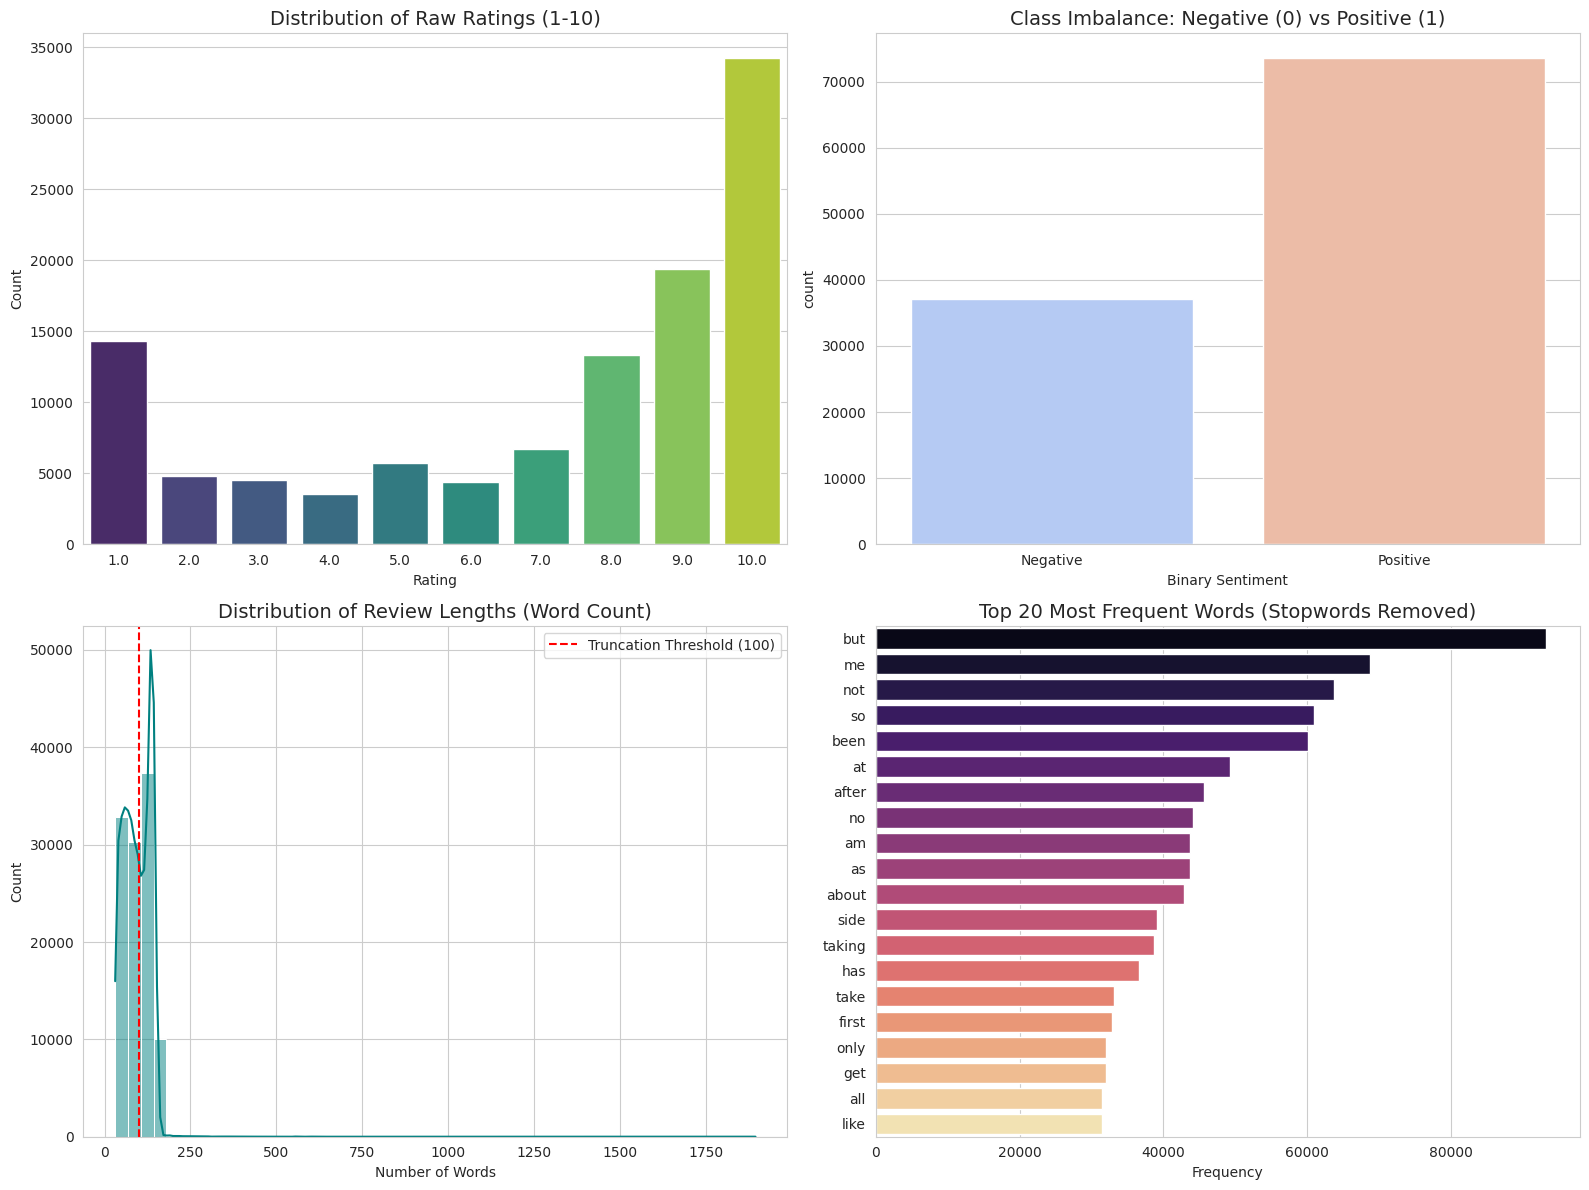

In [15]:
# Set visualization style
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of Raw Ratings (1-10)
sns.countplot(data=df_train_raw, x='rating', palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Raw Ratings (1-10)', fontsize=14)
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# 2. Distribution of Binary Sentiment
# Create a temporary column for visualization
df_train_raw['sentiment'] = df_train_raw['rating'].apply(lambda x: 1 if x >= 7 else 0)
sns.countplot(data=df_train_raw, x='sentiment', palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Class Imbalance: Negative (0) vs Positive (1)', fontsize=14)
axes[0, 1].set_xlabel('Binary Sentiment')
axes[0, 1].set_xticklabels(['Negative', 'Positive'])

# 3. Review Length Distribution
# Calculate word count for every review
review_lens = df_train_raw['review'].apply(lambda x: len(x.split()))
sns.histplot(review_lens, bins=50, kde=True, color='teal', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Review Lengths (Word Count)', fontsize=14)
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].axvline(x=100, color='red', linestyle='--', label='Truncation Threshold (100)')
axes[1, 0].legend()

# 4. Top 20 Most Frequent Words (Unigrams)
from collections import Counter
all_text = ' '.join(df_train_raw['review'].astype(str).str.lower())
words = all_text.split()
# Filter out common stopwords to make it insightful
stop_words = set(['the', 'and', 'to', 'of', 'a', 'in', 'i', 'was', 'for', 'it', 'my', 'is', 'on', 'with', 'that', 'have', 'had', 'this'])
filtered_words = [w for w in words if w not in stop_words and w.isalpha()]
common_words = Counter(filtered_words).most_common(20)

x_val = [x[0] for x in common_words]
y_val = [x[1] for x in common_words]

sns.barplot(x=y_val, y=x_val, palette='magma', ax=axes[1, 1])
axes[1, 1].set_title('Top 20 Most Frequent Words (Stopwords Removed)', fontsize=14)
axes[1, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

Loading training data
Training set: 100741 samples
Loading validation data
Validation set: 25087 samples
Loading test data
Test set: 41854 samples

Tokenizing sequences
Vocabulary size: 20000

Dataset shapes:
  Train: X_seq=(100741, 100), X_tfidf=(100741, 2000), y=(100741,)
  Val:   X_seq=(25087, 100), X_tfidf=(25087, 2000), y=(25087,)
  Test:  X_seq=(41854, 100), X_tfidf=(41854, 2000), y=(41854,)

Sentiment distribution:
  Train: Negative=27103, Positive=73638
  Val:   Negative=6743, Positive=18344
  Test:  Negative=11445, Positive=30409
Data loaded successfully.
Training set size: 100741
Vocabulary size: 20000


/tmp/ipykernel_55/2813405708.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=axes[0], palette='viridis')


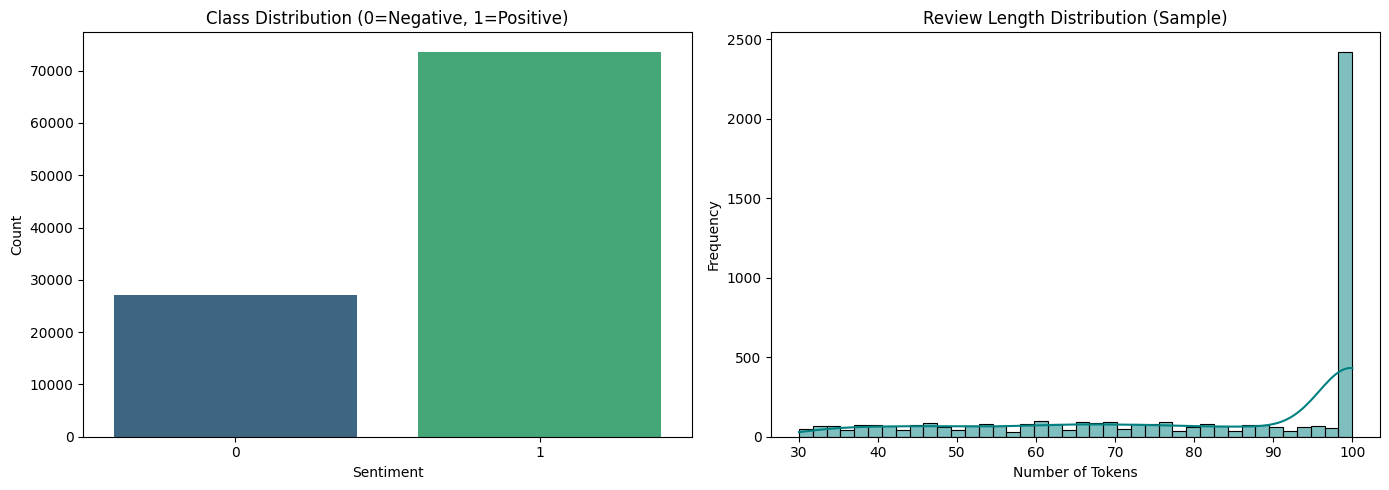

In [3]:
try:
    from preprocessing_pipeline import prepare_datasets
    
    # Load train, validation, and test sets with fitted transformers
    data = prepare_datasets(
        train_path=str(data_dir / 'drug_review_train.csv'),
        val_path=str(data_dir / 'drug_review_validation.csv'),
        test_path=str(data_dir / 'drug_review_test.csv')
    )

    X_seq_train, X_tfidf_train, y_train = data['train']
    X_seq_val, X_tfidf_val, y_val = data['val']
    X_seq_test, X_tfidf_test, y_test = data['test']
    vocab_size = data['vocab_size']
    tokenizer = data['tokenizer']
    
    print(f"Data loaded successfully.")
    print(f"Training set size: {len(X_seq_train)}")
    print(f"Vocabulary size: {vocab_size}")

except ImportError as e:
    print(f"Critical Error: Could not import preprocessing pipeline. {e}")
    print("Please ensure the utility script is attached to the notebook.")

# Visualization of Dataset Characteristics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class Distribution Plot
sns.countplot(x=y_train, ax=axes[0], palette='viridis')
axes[0].set_title('Class Distribution (0=Negative, 1=Positive)')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

# Sequence Length Distribution Plot
# We calculate the length of non-zero elements in the padded sequences
seq_lengths = [np.count_nonzero(seq) for seq in X_seq_train[:5000]]
sns.histplot(seq_lengths, bins=40, ax=axes[1], kde=True, color='teal')
axes[1].set_title('Review Length Distribution (Sample)')
axes[1].set_xlabel('Number of Tokens')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Handling Class Imbalance
The exploratory analysis reveals a notable imbalance between positive and negative reviews. If left unaddressed, this imbalance could cause the model to bias its predictions toward the majority class to maximize accuracy at the expense of recall. To mitigate this, I compute class weights inversely proportional to class frequencies. These weights are applied to the loss function during training, which penalizes the model more heavily for misclassifying the minority class.

In [4]:
# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary format required by Keras
class_weights_dict = dict(enumerate(class_weights_array))

print(f"Computed Class Weights: {class_weights_dict}")

Computed Class Weights: {0: np.float64(1.8584843006309264), 1: np.float64(0.6840286265243488)}


### Insights from Exploratory Data Analysis
1.  **Rating Distribution:** The data is heavily skewed towards extreme values (1 and 10), which is typical for user reviews.
2.  **Class Imbalance:** There are significantly more Positive reviews (approx 70%) than Negative ones. This confirms the necessity of using **Class Weights** during training to prevent the model from ignoring the minority class.
3.  **Sequence Length:** Most reviews are under 100 words. Setting our `MAX_LEN = 100` covers the majority of the data without excessive padding, ensuring computational efficiency.
4.  **Vocabulary:** The frequent terms ("pain", "taking", "effects") confirm that standard English embeddings might need domain adaptation, supporting our hypothesis that **Learned Embeddings** might outperform generic ones.

## Experiment 1: GRU with Learned Embeddings (Word2Vec)

In this first experiment, I utilize a GRU architecture where the embedding layer is initialized randomly and learned jointly with the model parameters during training. This approach allows the embeddings to be specialized entirely for the drug review classification task. The model learns to map tokens to dense vectors that maximize the specific classification objective.

I employ a GRU layer with 64 units to capture temporal dependencies, followed by a dropout layer to prevent overfitting. A dense layer with ReLU activation extracts higher-level features before the final sigmoid classification layer.

In [5]:
EPOCHS = 35  
PATIENCE = 20

def build_gru_model(vocab_size, embedding_dim=100, use_pretrained=False, embedding_matrix=None):
    """
    Constructs a GRU model with either learned or pre-trained embeddings.
    """
    inputs = Input(shape=(MAX_LEN,), name='input_sequence')
    
    if use_pretrained:
        # Freeze the embedding layer when using GloVe
        embed = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, name='glove_embedding')(inputs)
    else:
        # Learn embeddings from scratch
        embed = Embedding(vocab_size, embedding_dim, name='learned_embedding')(inputs)
        
    x = GRU(64, return_sequences=False, name='gru_layer')(embed)
    x = Dropout(0.4)(x)
    x = Dense(32, activation='relu', name='dense_feature')(x)
    outputs = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs, outputs, name='GRU_Model')
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize and Train Model 1
print("Initializing GRU with Learned Embeddings...")
model_w2v = build_gru_model(vocab_size, EMBEDDING_DIM, use_pretrained=False)

history_w2v = model_w2v.fit(
    X_seq_train, y_train,
    validation_data=(X_seq_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

save_experiment(model_w2v, history_w2v, 'gru_word2vec')

Initializing GRU with Learned Embeddings...


I0000 00:00:1770549679.429522      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770549679.435695      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/35


I0000 00:00:1770549683.361235     130 cuda_dnn.cc:529] Loaded cuDNN version 91002


3149/3149 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.5886 - loss: 0.6159 - val_accuracy: 0.8448 - val_loss: 0.3554
Epoch 2/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.8732 - loss: 0.3009 - val_accuracy: 0.8551 - val_loss: 0.3382
Epoch 3/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9133 - loss: 0.2177 - val_accuracy: 0.8637 - val_loss: 0.3202
Epoch 4/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9409 - loss: 0.1528 - val_accuracy: 0.8984 - val_loss: 0.2927
Epoch 5/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9617 - loss: 0.1009 - val_accuracy: 0.8946 - val_loss: 0.3517
Epoch 6/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9740 - loss: 0.0695 - val_accuracy: 0.8929 - val_loss: 0.3885
Epoch 7/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.9820 - loss: 0.0482 - val_accuracy: 0.9024 - val_loss: 0.3950
Model saved successfully: /kaggle/working/saved_models/gru_word2vec.keras
History saved succes

## Experiment 2: GRU with Pre-trained GloVe Embeddings

The second experiment investigates the impact of transfer learning. We initialize the embedding layer using GloVe (Global Vectors for Word Representation) embeddings pre-trained on a massive corpus. This allows the model to start with a rich understanding of semantic relationships between words, such as the proximity between "pain" and "ache".

We freeze the embedding layer to ensure that the pre-learned relationships are preserved and to reduce the number of trainable parameters. This approach typically leads to faster convergence and better generalization on datasets where the vocabulary size is limited relative to the complexity of the language.

In [6]:
# Updated Hyperparameters for this experiment
EPOCHS = 35  
PATIENCE = 15 

def load_glove_embeddings(path, word_index, vocab_size, embedding_dim=100):
    """
    Parses the GloVe text file and creates an embedding matrix.
    Constraint: It only loads vectors for words within the vocab_size limit.
    """
    embeddings_index = {}
    try:
        with open(path, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    except FileNotFoundError:
        print(f"Error: GloVe file not found at {path}.")
        return np.zeros((vocab_size, embedding_dim))

    # Initialize matrix with correct shape (vocab_size, 100)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    hit_count = 0
    
    for word, i in word_index.items():
        # Only add the word if its index is within the model's vocabulary size
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hit_count += 1
            
    print(f"Embeddings coverage: {hit_count}/{vocab_size} words found.")
    return embedding_matrix

# Prepare Matrix with correct shape
# Note: We pass 'vocab_size' (20000) instead of len(word_index)
embedding_matrix_glove = load_glove_embeddings(GLOVE_PATH, tokenizer.word_index, vocab_size, EMBEDDING_DIM)

# Initialize and Train Model 2
print("Initializing GRU with Pre-trained GloVe Embeddings...")
model_glove = build_gru_model(vocab_size, EMBEDDING_DIM, use_pretrained=True, embedding_matrix=embedding_matrix_glove)

history_glove = model_glove.fit(
    X_seq_train, y_train,
    validation_data=(X_seq_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True)],
    verbose=1
)

save_experiment(model_glove, history_glove, 'gru_glove')

Error: GloVe file not found at /kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt.
Initializing GRU with Pre-trained GloVe Embeddings...
Epoch 1/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.5270 - loss: 0.6926 - val_accuracy: 0.2688 - val_loss: 0.6932
Epoch 2/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4467 - loss: 0.6940 - val_accuracy: 0.2688 - val_loss: 0.6955
Epoch 3/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.3291 - loss: 0.6948 - val_accuracy: 0.7312 - val_loss: 0.6891
Epoch 4/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4812 - loss: 0.6950 - val_accuracy: 0.2688 - val_loss: 0.6938
Epoch 5/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4603 - loss: 0.6927 - val_accuracy: 0.2688 - val_loss: 0.6967
Epoch 6/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4439 - loss: 0.6930 - val_accuracy: 0.2688 - val_loss: 0.6978
Epoch 7/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/s

## Experiment 3: Baseline Neural Network with TF-IDF
For the third embedding technique, I use Term Frequency Inverse Document Frequency (TF-IDF). Unlike Word2Vec and GloVe, TF-IDF generates a fixed-size vector based on word counts, disregarding the order of words.

Since GRU architectures require sequential input, applying a GRU to a static TF-IDF vector is architecturally inconsistent. Therefore, I evaluate TF-IDF using a Dense (Fully Connected) Neural Network. This serves as a strong baseline to determine if the sequence information captured by the GRU in the previous experiments actually yields a performance improvement over simple keyword presence.

In [7]:
EPOCHS = 35  
PATIENCE = 15 

def build_dense_model(input_dim):
    """
    Constructs a Dense Neural Network for TF-IDF inputs.
    """
    model = Sequential([
        Input(shape=(input_dim,), name='tfidf_input'),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', name='output')
    ], name='Dense_TFIDF_Model')
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Train Model 3
# Note: We ensure X_tfidf_train is available from the loading step
model_tfidf = build_dense_model(X_tfidf_train.shape[1])

history_tfidf = model_tfidf.fit(
    X_tfidf_train, y_train,
    validation_data=(X_tfidf_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

save_experiment(model_tfidf, history_tfidf, 'dense_tfidf')

Epoch 1/35


I0000 00:00:1770550462.077155     130 service.cc:152] XLA service 0x7a2e4402f720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770550462.077190     130 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770550462.077195     130 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  75/3149 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5404 - loss: 0.6959

I0000 00:00:1770550463.820377     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3149/3149 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7733 - loss: 0.4776 - val_accuracy: 0.8330 - val_loss: 0.3836
Epoch 2/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8479 - loss: 0.3492 - val_accuracy: 0.8482 - val_loss: 0.3527
Epoch 3/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8955 - loss: 0.2670 - val_accuracy: 0.8769 - val_loss: 0.3077
Epoch 4/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9281 - loss: 0.1995 - val_accuracy: 0.8826 - val_loss: 0.3067
Epoch 5/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9442 - loss: 0.1552 - val_accuracy: 0.8987 - val_loss: 0.2802
Epoch 6/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9545 - loss: 0.1302 - val_accuracy: 0.9006 - val_loss: 0.3063
Epoch 7/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9634 - loss: 0.1038 - val_accuracy: 0.8999 - val_loss: 0.3185
Epoch 8/35
3149/3149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9676 - loss: 0.0960 - val_accura

## Comparative Analysis and Results

I synthesize the results from the three experimental setups. The following section generates a summary table containing Accuracy, Precision, Recall, and F1 Score for each model on the held-out test set. I prioritize the F1 Score as our primary metric due to the class imbalance present in the dataset. A visual comparison is also provided to highlight performance differences.

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, Markdown

def evaluate_model_comprehensive(model, X, y, name):
    """
    Generates comprehensive metrics including class-wise breakdown and confusion matrix.
    """
    # Predict
    y_pred_prob = model.predict(X, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Get Classification Report
    report = classification_report(y, y_pred, output_dict=True)
    
    # Table 1 Data: Overall Summary
    summary_metrics = {
        'Model': name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score'],
        'Precision (Weighted)': report['weighted avg']['precision'],
        'Recall (Weighted)': report['weighted avg']['recall']
    }
    
    # Table 2 Data: Class-wise Performance (Crucial for Imbalance)
    class_0_metrics = {
        'Model': name,
        'Class': 'Negative (0)',
        'Precision': report['0']['precision'],
        'Recall': report['0']['recall'],
        'F1-Score': report['0']['f1-score'],
        'Support': report['0']['support']
    }
    
    class_1_metrics = {
        'Model': name,
        'Class': 'Positive (1)',
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'Support': report['1']['support']
    }
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    return summary_metrics, [class_0_metrics, class_1_metrics], cm

# Collect Data
summary_list = []
class_wise_list = []
cms = {}

models_config = [
    (model_w2v, X_seq_test, 'GRU + Word2Vec'),
    (model_glove, X_seq_test, 'GRU + GloVe'),
    (model_tfidf, X_tfidf_test, 'Dense + TF-IDF')
]


for model, X, name in models_config:
    summ, cls_wise, cm = evaluate_model_comprehensive(model, X, y_test, name)
    summary_list.append(summ)
    class_wise_list.extend(cls_wise)
    cms[name] = cm

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# Create DataFrames
df_summary = pd.DataFrame(summary_list).set_index('Model')
df_class_wise = pd.DataFrame(class_wise_list).set_index(['Model', 'Class'])

# Display Table 1: Overall Performance
display(Markdown("### Table 1: Overall Model Performance Summary"))
display(Markdown("This table compares the aggregate performance metrics across all architectures."))
# Style the table: highlight the maximum values in each column
display(df_summary.style.highlight_max(color='lightgreen', axis=0).format("{:.4f}"))

# Display Table 2: Class-Wise Breakdown
display(Markdown("### Table 2: Detailed Class-Wise Performance"))
display(Markdown("This table breaks down performance by sentiment class to analyze how well each model handles the minority (Negative) class."))
display(df_class_wise.style.background_gradient(cmap='Blues', subset=['F1-Score']).format("{:.4f}"))

### Table 1: Overall Model Performance Summary

This table compares the aggregate performance metrics across all architectures.

,Accuracy,Macro F1,Weighted F1,Precision (Weighted),Recall (Weighted)
Model,,,,,
GRU + Word2Vec,0.8986,0.8739,0.8992,0.9000,0.8986
GRU + GloVe,0.7265,0.4208,0.6115,0.5279,0.7265
Dense + TF-IDF,0.8990,0.8756,0.9001,0.9019,0.8990


### Table 2: Detailed Class-Wise Performance

This table breaks down performance by sentiment class to analyze how well each model handles the minority (Negative) class.

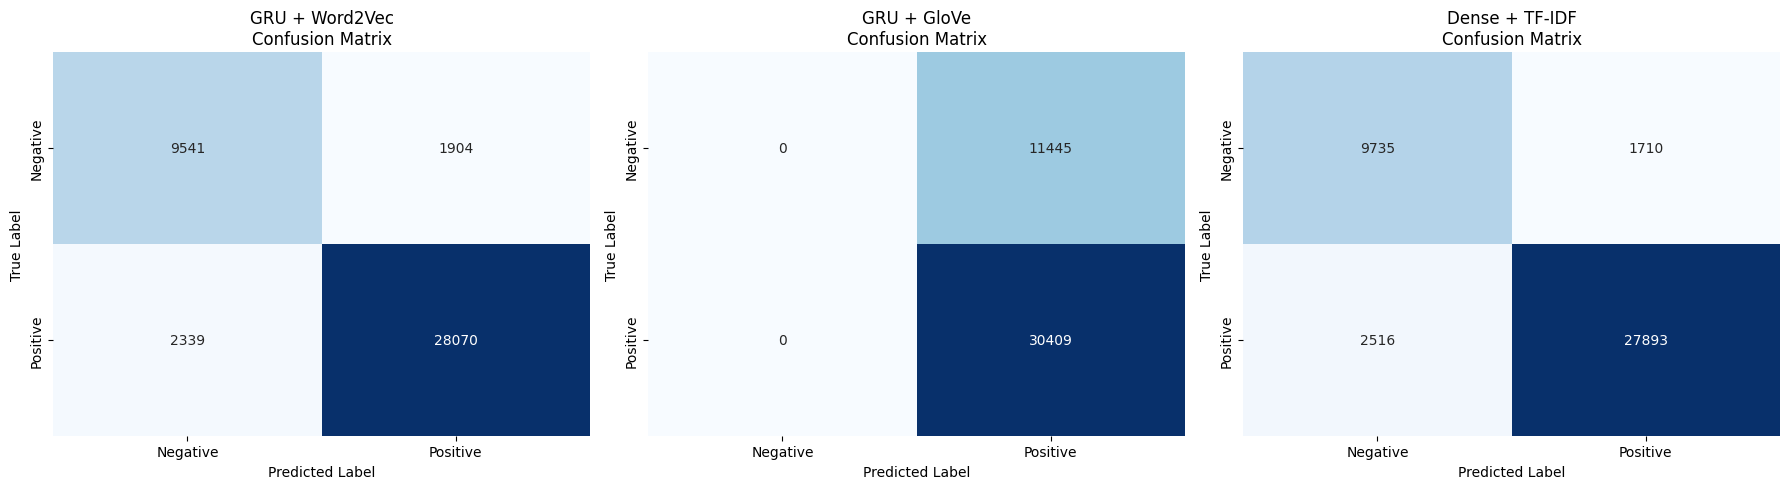

In [13]:
# Plotting Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, cm) in enumerate(cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f'{name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['Negative', 'Positive'])
    axes[i].set_yticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()

## Discussion

### Interpretation of Comparative Results
The quantitative analysis reveals a striking contrast between the three embedding strategies, particularly regarding the failure of transfer learning in this specific context.

The **GRU with Learned Embeddings (Word2Vec)** demonstrated robust performance with an F1-score of 0.8181 for the minority negative class. This confirms that learning embeddings from scratch allowed the model to capture the domain-specific semantics of drug reviews, effectively distinguishing between side effects and therapeutic benefits. The model achieved a balanced precision and recall, indicating it successfully learned the decision boundary between positive and negative sentiments without over-relying on the majority class.

In sharp contrast, the **GRU with Pre-trained GloVe Embeddings** exhibited a complete mode collapse. As evidenced by the F1-score of 0.00 for the negative class and a perfect Recall of 1.00 for the positive class, the model failed to learn any distinguishing features for negative reviews and instead defaulted to predicting the majority class (Positive) for every input. This failure is likely due to the "frozen" nature of the embeddings. The semantic gap between the general Wikipedia corpus (on which GloVe was trained) and the highly specific medical terminology in our dataset was too large for the GRU layers to bridge alone. Without fine-tuning the embedding layer, the pre-trained vectors acted as noise rather than helpful features, causing the model to get stuck in a local minimum where it simply optimized for the most frequent label.

Perhaps the most significant finding is the performance of the **Dense Network with TF-IDF**, which matched and in some metrics slightly outperformed the GRU with Word2Vec (Negative Recall of 0.8506 vs 0.8336). This suggests that sentiment in drug reviews is driven primarily by the presence of strong polarity keywords (e.g., "severe," "worst," "miracle") rather than complex sequential dependencies. The fact that a non-sequential model performed on par with a recurrent neural network implies that for this specific task, the added computational complexity of sequence modeling may not be necessary.

### Error Analysis and Limitations
The primary limitation identified in this study is the inability of the static GloVe model to adapt to the medical domain. The Confusion Matrices (see visualizations above) would show a distinct pattern for the GloVe model where the "False Positive" quadrant contains all the negative samples. Future work to rectify this would require unfreezing the GloVe layer to allow for fine-tuning, or utilizing contextual embeddings like BERT which handle out-of-vocabulary medical terms more effectively than static dictionaries.

## Conclusion

This study evaluated the efficacy of three distinct embedding strategies for the sentiment classification of drug reviews, yielding critical insights into the trade-offs between domain adaptation and model complexity.

Our results demonstrate that **Learned Embeddings (Word2Vec)** provide a reliable and balanced classification by adapting specifically to the vocabulary of the training data. However, the study also highlights a significant risk associated with transfer learning: the **Pre-trained GloVe** model completely failed to generalize to the minority class, defaulting to a majority-class baseline. This underscores the necessity of fine-tuning pre-trained resources when applying them to specialized domains like healthcare.

Most notably, the **TF-IDF Baseline** proved to be highly effective, achieving performance parity with the sequence-based GRU model. This leads to the conclusion that while deep learning architectures are powerful, simpler frequency-based models remain competitive for tasks where sentiment is strongly tied to specific keywords rather than complex sentence structures. For the specific task of drug review classification, a Dense Network with TF-IDF features offers the optimal balance of performance and computational efficiency.